# 00 ZeroNet

まずはスタート地点として『ゼロから作るDeep Learning』の８章のＣＮＮを PyTorch で実装する。
ZeroNet （勝手に命名）

* 3 x 3 のフィルターを基本とした VGG-16 の簡略版
* conv - conv - pool - conv - conv - pool - fully - dropout - fully - dropout - softmax 

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F  # F.relu とか

print('PyTorch version', torch.__version__)

# GPU が動いていることを確認
print('GPU available: ', torch.cuda.is_available())
print('GPU:', torch.cuda.get_device_name(0))

PyTorch version 1.1.0
GPU available:  True
GPU: Quadro K620


## MNIST data

In [7]:
# torchvision を使って MNIST データをロード。初回はダウンロードする。
# デフォルトではデータが PIL.Image なので Tensor に変換する
to_tensor = torchvision.transforms.ToTensor()

train = torchvision.datasets.MNIST(root='../input', train=True,
                                   download=True, transform=to_tensor)
test = torchvision.datasets.MNIST(root='../input', train=False,
                                  transform=to_tensor)
print(train)
print(test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../input
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../input
    Split: Test


## datasets とは

`__len__` と `__getitem__` を持っている。この二つがあれば、`DataLoader` で使えるらしい。

```python
class MyDataSet(VisionDataset):
    def __len__():
        pass
    
    def __getitem__():
        pass
```



```python
d = MyDataSet()
len(d)      # データ総数
X, y = d[i] # feature と label を返す
```




In [8]:
# DataLoader
# 学習時に mini batch に切り分けてくれる
batch_size = 100
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

image shape (1, 28, 28)


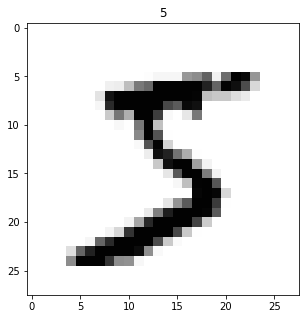

In [9]:
img, label = train[0]

print('image shape', tuple(img.shape))

plt.figure(figsize=(5,5))
plt.title(label)
plt.imshow(img[0, :, :], cmap='Greys') # img[channel, x, y] なので channel = 0 を表示
plt.show()

## CNN

ネットワークを定義する

In [15]:
class ZeroNet(nn.Module):
    def __init__(self):
        # ここでは各レイヤーを定義しているだけ。繋がっていない
        # Sequential を使って __init__ 時点でつなぐ流儀もある
        super(ZeroNet, self).__init__()
        self.conv1a = nn.Conv2d(1, 16, 3, padding=1)   # 28x28x1 -> 28x28x16
        self.conv1b = nn.Conv2d(16, 16, 3, padding=1)  # 28x28x16 -> 28x28x16 
        self.pool1 = nn.MaxPool2d(2, 2)                # 28x28x16 -> 14x14x16
        self.conv2a = nn.Conv2d(16, 32, 3, padding=1)  # 14x14x16 -> 14x14x32
        self.conv2b = nn.Conv2d(32, 32, 3, padding=2)  # 14x14x32 -> 15x15x32
        self.pool2 = nn.MaxPool2d(2, 2)                # 15x15x32 -> 8x8x32
        self.conv3a = nn.Conv2d(32, 64, 3, padding=1)  # 8x8x32 -> 8x8x64
        self.conv3b = nn.Conv2d(64, 64, 3, padding=1)  # 8x8x64 -> 8x8x64
        self.pool3 = nn.MaxPool2d(2, 2)                # 8x8x64 -> 4x4x64
        self.fc1 = nn.Linear(64 * 4 * 4, 50)           # fully connected 50
        self.dropout1 = nn.Dropout2d()
        self.fc2 = nn.Linear(50, 10)                   # 10 is the number of classes
        self.dropout2 = nn.Dropout2d()

    def forward(self, x):
        # レイヤーをつなげている
        x = F.relu(self.conv1a(x))
        x = F.relu(self.conv1b(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2a(x))
        x = F.relu(self.conv2b(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv3a(x))
        x = F.relu(self.conv3b(x))
        x = self.pool3(x)
        
        x = x.view(-1, 4 * 4 * 64)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.dropout2(x)

        return x

net = ZeroNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training

最小限のコードは

```python
epochs = 10

for iepoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader, 0): 
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
```

いろいろ測定と追加する

* かかった時間
* Loss と Accuracy

In [19]:
epochs = 20
losses_train = []
losses_test = []
scores_test = []
times_train = []
times_test = []

for iepoch in range(epochs):
    time_train = 0.0
    loss_train = 0.0
    for i, (images, labels) in enumerate(train_loader, 0): 
        ts = time.time_ns() / (10 ** 9)
            
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        te = time.time_ns() / (10 ** 9)
        time_train += (te - ts)

        loss_train += loss.item()

    # average loss during the epoch
    loss_train /= len(train_loader)
    losses_train.append(loss_train)
    
    times_train.append(time_train)
    
    # For each epoch
    ts = time.time_ns() / (10 ** 9)
        
    loss_test = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader, 0):
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss_test += loss
                
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    te = time.time_ns() / (10 ** 9)
    times_test.append(te - ts)
    
    loss_test /= len(test_loader)
    losses_test.append(loss_test)
    scores_test.append(100 * correct / total)
    

    print('Epoch %d: loss %.4e %.4e, Test accuracy %d/%d %.4f %%' %
          (iepoch + 1, loss_train, loss_test,
           correct, total, (100 * correct / total)))

    
print('Finished Training')
print('Training %.2f ± %.2f sec per epoch' % (np.mean(times_train), np.std(times_train)))
print('Test evaluation %.4f ± %.4f sec per epoch' % (np.mean(times_test), np.std(times_test)))

Epoch 1: loss 9.2688e-01 9.2007e-01, Test accuracy 5802/10000 58.0200 %
Epoch 2: loss 9.1714e-01 9.1914e-01, Test accuracy 5846/10000 58.4600 %
Epoch 3: loss 9.2093e-01 9.1034e-01, Test accuracy 5871/10000 58.7100 %
Epoch 4: loss 9.1366e-01 9.2463e-01, Test accuracy 5838/10000 58.3800 %
Epoch 5: loss 9.0110e-01 9.1915e-01, Test accuracy 5848/10000 58.4800 %
Epoch 6: loss 9.0347e-01 9.3018e-01, Test accuracy 5819/10000 58.1900 %
Epoch 7: loss 9.0220e-01 9.1368e-01, Test accuracy 5845/10000 58.4500 %
Epoch 8: loss 8.9686e-01 9.1771e-01, Test accuracy 5897/10000 58.9700 %
Epoch 9: loss 8.9382e-01 9.3365e-01, Test accuracy 5793/10000 57.9300 %
Epoch 10: loss 8.9610e-01 9.0464e-01, Test accuracy 5882/10000 58.8200 %
Epoch 11: loss 8.9328e-01 9.1197e-01, Test accuracy 5886/10000 58.8600 %
Epoch 12: loss 8.8384e-01 9.1752e-01, Test accuracy 5800/10000 58.0000 %
Epoch 13: loss 8.9571e-01 8.9531e-01, Test accuracy 5882/10000 58.8200 %
Epoch 14: loss 8.8334e-01 9.2406e-01, Test accuracy 5783/100

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('epochs')
plt.plot(losses_train, label='train')
plt.plot(losses_test, label='test')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('epochs')
plt.plot(scores_test, label='train')


CPU


